In [1]:
!pip install -U ogb --quiet
!pip install urllib3 --quiet
!pip install dgl --quiet
!pip install rdkit --quiet
!pip install plotnine --quiet
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
Looking in links: https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html


In [2]:
import os
import torch
from ogb.linkproppred import PygLinkPropPredDataset
from ogb.nodeproppred import PygNodePropPredDataset
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import InMemoryDataset
from ogb.nodeproppred import NodePropPredDataset
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
import numpy as np
import pandas as pd
import urllib3
import outdated
import dgl
import sklearn
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch_geometric.nn import GraphConv
import matplotlib.pyplot as plt
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
from params import gnn_params, rgcn_params
from gcn import GCN

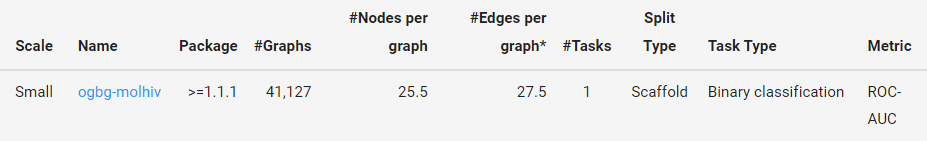

In [3]:
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/')
split_idx = dataset.get_idx_split() 
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False)

Downloaded 0.00 GB: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|█████████████████████████████████████████████████████████████████████████| 41127/41127 [00:00<00:00, 94336.16it/s]


Converting graphs into PyG objects...


100%|█████████████████████████████████████████████████████████████████████████| 41127/41127 [00:00<00:00, 49340.98it/s]


Saving...


Done!
C:\Users\cs843\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
dataset[0]

Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)

In [5]:
dir(dataset.data)

['__call__',
 '__cat_dim__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__inc__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_all_edges_to_layout',
 '_edge_attr_cls',
 '_edge_to_layout',
 '_get_edge_index',
 '_get_tensor',
 '_get_tensor_size',
 '_multi_get_tensor',
 '_put_edge_index',
 '_put_tensor',
 '_remove_tensor',
 '_store',
 '_tensor_attr_cls',
 '_to_type',
 'apply',
 'apply_',
 'batch',
 'clone',
 'coalesce',
 'contains_isolated_nodes',
 'contains_self_loops',
 'contiguous',
 'coo',
 'cpu',
 'csc',
 'csr',
 'cuda',
 'debug',
 'de

In [6]:
dataset.data.has_isolated_nodes()

True

In [14]:
num_nodes = dataset.data.num_nodes
num_edges = dataset.data.num_edges // 2
train_len = len(dataset[split_idx["train"]])
val_len =len(dataset[split_idx["valid"]])
test_len = len(dataset[split_idx["test"]])
other_len = num_nodes - train_len - val_len - test_len
print(f"Dataset: {dataset.name}")
print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
print(f"Num. edges: {num_edges}")
print(f"Num. node features: {dataset.num_node_features}")
print(f"Num. classes: {dataset.num_classes}")
print(f"Dataset len.: {dataset.len()}")
print(" ")

Dataset: ogbg-molhiv
Num. nodes: 1049163 (train=32901, val=4113, test=4113, other=1008036)
Num. edges: 1129688
Num. node features: 9
Num. classes: 2
Dataset len.: 41127
 


In [ ]:
len(train_loader)

 Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not. 

In [ ]:
len(dataset.data.x)
dataset.data.x[0]

As looking at the functions in the code: https://github.com/snap-stanford/ogb/blob/master/ogb/utils/features.py  belioeve that the futures:
1) atomic_number <br> 
2)chirality<br> 
3)degree <br> 
4)formal charge<br> 
5)num of Hs<br> 
6)num of radical_e <br> 
7)hybridisation<br> 
8)is aromatic<br> 
9)is_in_ring<br> 

uses same atom_feature as atom_to_feature_vector test<br> 
atom_feature_dict = atom_feature_vector_to_dict(atom_feature)<br> <br> 
assert atom_feature_dict['atomic_num'] == 6<br> 
assert atom_feature_dict['chirality'] == 'CHI_TETRAHEDRAL_CCW'<br> 
assert atom_feature_dict['degree'] == 4<br> 
assert atom_feature_dict['formal_charge'] == 0<br>
assert atom_feature_dict['num_h'] == 1<br> 
assert atom_feature_dict['num_rad_e'] == 0<br> 
assert atom_feature_dict['hybridization'] == 'SP3'<br> 
assert atom_feature_dict['is_aromatic'] == False<br> 
assert atom_feature_dict['is_in_ring'] == False<br> 



AtomEncoder and BondEncoder. They can be used as follows to embed raw atom and bond features to obtain atom_emb and bond_emb

Edge features <br> 
1)_Bond Type 
2)Bond Stereo
3)Is conjugated 

In [ ]:
atom_encoder = AtomEncoder(emb_dim = 100)
bond_encoder = BondEncoder(emb_dim = 100)
atom_emb = atom_encoder(x) # x is the input atom feature
edge_emb = bond_encoder(edge_attr) # edge_attr is the input edge feature

# Prediction task as in the paper: https://github.com/thibmonsel/DL_Project/blob/master/GNNs_Project.pdf

The task is to predict the target molecular properties as accurately as possible, where the molecular properties are cast as binary labels, e.g, whether a molecule inhibits HIV virus replication or not. 

# Training and Testing loops

In [10]:
def train(model, device, train_loader, loss_fn, optimizer):
    model.train()
    
    running_train_loss = 0
    for step, data in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data)
        loss = loss_fn(out, data.y.to(out.dtype))
        running_train_loss += loss.item() * len(data.y)
        loss.backward()
        optimizer.step()
    return running_train_loss / len(train_loader.dataset)

def eval(model,device, loader, evaluator):
    model.eval()
        
    running_eval_loss = 0
    concat_prediction, concat_target = torch.empty(0,1), torch.empty(0,1)
    with torch.no_grad():
        for step, data in enumerate(loader):
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = loss_fn(out, data.y.to(out.dtype))
            running_eval_loss += loss.item() * len(data.y)
            concat_prediction = torch.cat((concat_prediction, out.cpu()), 0)
            concat_target = torch.cat((concat_target, data.y.cpu()), 0)
        
        input_dict = {"y_true": concat_target.numpy(), "y_pred": concat_prediction.numpy()}
    return evaluator.eval(input_dict)['rocauc'], running_eval_loss / len(loader.dataset)

In [11]:
evaluator = Evaluator("ogbg-molhiv") 

In [8]:
evaluator

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 1
parameters = gnn_params 
model = GCN(*parameters.values())

In [13]:
model.to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()

test_perfs = []
for run in range(1,11) :
    print(f'Run {run}:')

    model.reset_parameters()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05) 

    results = {'highest_valid': 0,
            'final_train': 0,
            'final_test': 0,
            'highest_train': 0}

    for epoch in range(EPOCHS):
        loss = train(model, device, train_loader, loss_fn, optimizer) 
        train_roc, _ = eval(model,device, train_loader, evaluator)
        valid_roc, _ = eval(model,device, valid_loader, evaluator)
        test_roc, _ = eval(model, device, test_loader, evaluator)

        if train_roc > results['highest_train']:
            results['highest_train'] = train_roc

        if valid_roc > results['highest_valid']:
            results['highest_valid'] = valid_roc
            results['final_train'] = train_roc
            results['final_test'] = test_roc

        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train: {train_roc:.4f}, Val: {valid_roc:.4f}, '
          f'Test: {test_roc:.4f}') 

    #print("Post training Results {}".format(results))

    test_perfs.append(results['final_test'])

test_perf = torch.tensor(test_perfs)
print('===========================')
print("model parameters : {}".format(parameters))
print(f'Final Test: {test_perf.mean():.4f} ± {test_perf.std():.4f}')


Run 1:
Epoch: 000, Loss: 0.1609, Train: 0.7110, Val: 0.7153, Test: 0.6854
Run 2:
Epoch: 000, Loss: 0.1641, Train: 0.7109, Val: 0.7319, Test: 0.6707
Run 3:
Epoch: 000, Loss: 0.1621, Train: 0.6945, Val: 0.6988, Test: 0.6832
Run 4:
Epoch: 000, Loss: 0.1604, Train: 0.6936, Val: 0.6952, Test: 0.7145
Run 5:
Epoch: 000, Loss: 0.1587, Train: 0.6954, Val: 0.7349, Test: 0.6891
Run 6:
Epoch: 000, Loss: 0.1607, Train: 0.7146, Val: 0.6927, Test: 0.6865
Run 7:
Epoch: 000, Loss: 0.1625, Train: 0.7035, Val: 0.7091, Test: 0.6893
Run 8:
Epoch: 000, Loss: 0.1594, Train: 0.7036, Val: 0.6913, Test: 0.6988
Run 9:
Epoch: 000, Loss: 0.1598, Train: 0.7087, Val: 0.7351, Test: 0.7001
Run 10:
Epoch: 000, Loss: 0.1596, Train: 0.7210, Val: 0.7139, Test: 0.6938
model parameters : {'in_channel': 100, 'number_hidden_layers': 0, 'aggregator': 'max', 'hidden_out_channel': 64, 'out_channel': 32, 'pool_layer': 'mean', 'k': 1}
Final Test: 0.6911 ± 0.0117
